In [214]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 140
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 94 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[fn_spec-start_nirspec7] - sky_total) / (average_flat_field - average_flat_lamp_off)
#sky_subtracted[sky_subtracted>0.2] = 0.2
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
#plt.figure(figsize=(12,6))
#plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.xlabel('Wavelength Axis')
#plt.ylabel('Spatial Axis')
#plt.gca().invert_yaxis()
#plt.xlim(50,150)
#plt.ylim(40,130)
#plt.colorbar(orientation='horizontal', pad=0.1)

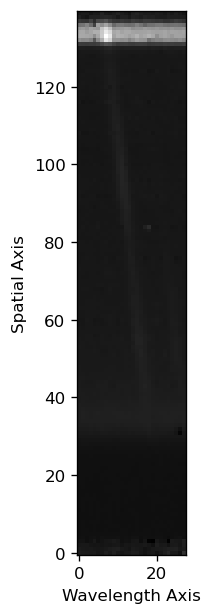

In [223]:
a = np.delete(sky_subtracted, np.s_[200:1024], 1)
b = np.delete(a, np.s_[:85], 1)
c = np.delete(b, np.s_[28:], 1)

plt.figure(figsize=(12,6))
plt.imshow(c, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
#plt.xlim(0,5)

In [212]:
c.shape

(140, 25)

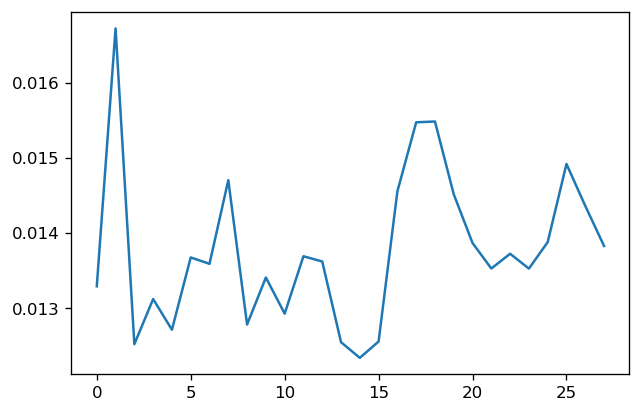

In [96]:
ind = 37
plt.plot(c[ind])

In [261]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# confirm start and end frame number
fn_start = 87
fn_end = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# create empty list to collect result
h2_a0_map = []
h2_a1_map = []
h2_a2_map = []


print('H2 LOOP START')
print()
# scan selected range of frames
for fn in range(fn_start, fn_end):
    # check if selected frame is a sky frame
    if fn in sky_frame:
        print('Frame Number = ' + str(fn) + '(Sky Frame)')
        print()
        continue
    # perform sky subtraction
    skyfinal = scale_sky_frame(fn)
    sky_subtract = (nirspec7_data_array[fn-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    # select waverange for gaussian fit
    a = np.delete(sky_subtract, np.s_[200:1024], 1)
    b = np.delete(a, np.s_[:85], 1)
    c = np.delete(b, np.s_[28:], 1)
    
    # define new wavlength axis
    pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
    
    # partition frame numbers to account for change in spatial axis
    if fn >= fn_start and fn < fn_end:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 127
        lower_h2 = 37

        h2_a0 = []
        h2_a1 = []
        h2_a2 = []
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 90 and i < upper_h2:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.03)
                h2_params.add('a1', value=11)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
    
            if i >= 60 and i < 90:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=14)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
    
            if i >= lower_h2 and i < 60:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=17)
                h2_params.add('a2', value=2.5)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
        
        print()
        
    # Collect fitting parameters of each frame number   
    h2_a0_map.append(np.array(h2_a0))
    h2_a1_map.append(np.array(h2_a1))
    h2_a2_map.append(np.array(h2_a2))
    
print('DONE')

H2 LOOP START

Frame Number = 87
ValueError occured at i=99
ValueError occured at i=100

Frame Number = 88
ValueError occured at i=120
ValueError occured at i=121
ValueError occured at i=122
ValueError occured at i=123

Frame Number = 89
ValueError occured at i=124

Frame Number = 90

Frame Number = 91(Sky Frame)

Frame Number = 92

Frame Number = 93
ValueError occured at i=39

Frame Number = 94
ValueError occured at i=37

Frame Number = 95
ValueError occured at i=40

Frame Number = 96
ValueError occured at i=39
ValueError occured at i=40

Frame Number = 97
ValueError occured at i=38
ValueError occured at i=84

Frame Number = 98
ValueError occured at i=39
ValueError occured at i=40
ValueError occured at i=43
ValueError occured at i=44

Frame Number = 99
ValueError occured at i=124
ValueError occured at i=125
ValueError occured at i=126

Frame Number = 100
ValueError occured at i=40
ValueError occured at i=100

Frame Number = 101
ValueError occured at i=44

Frame Number = 102
ValueError

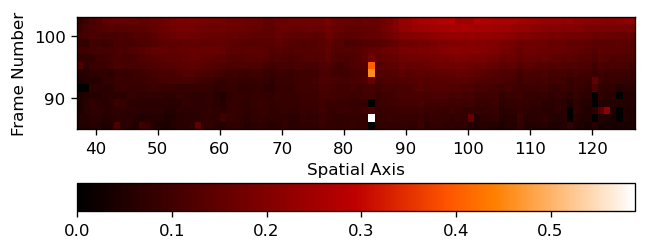

In [262]:
h2a0 = np.vstack(h2_a0_map)
h2a0[h2a0>0.5] = 0
h2a0[h2a0<0] = 0

plt.imshow(np.sqrt(h2a0), extent=[lower_h2, upper_h2, start_kband_north, end_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.colorbar(orientation='horizontal', pad=0.15)

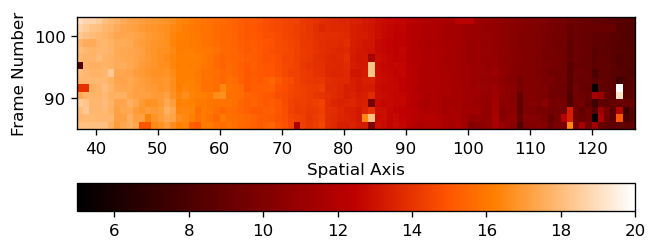

In [263]:
h2a1 = np.vstack(h2_a1_map)
h2a1[h2a1<5] = 5
h2a1[h2a1>20] = 20

plt.imshow(h2a1, extent=[lower_h2, upper_h2, start_kband_north, end_kband_north], cmap='gist_heat')
#plt.imshow(h2a1-(np.sum(h2a1, axis=0)/len(h2a1)), extent=[lower_h2, upper_h2, start_kband_north, end_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.colorbar(orientation='horizontal', pad=0.15)

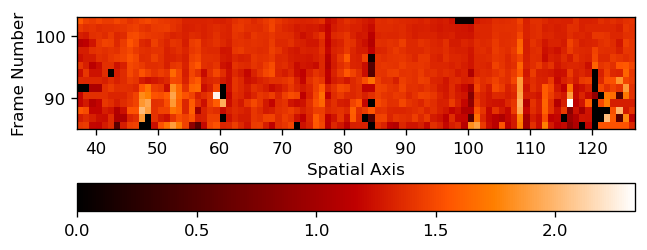

In [264]:
h2a2 = np.vstack(h2_a2_map)
h2a2[h2a2>2.5] = 0
h2a2[h2a2<0] = 0

plt.imshow(h2a2, extent=[lower_h2, upper_h2, start_kband_north, end_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.colorbar(orientation='horizontal', pad=0.15)

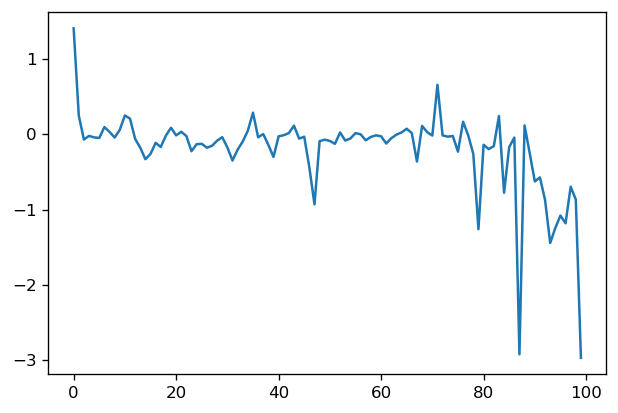

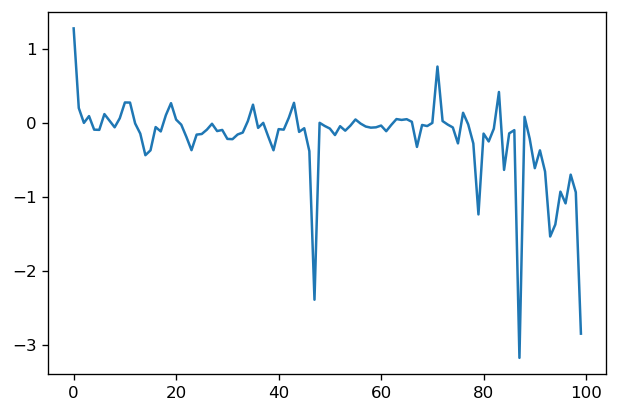

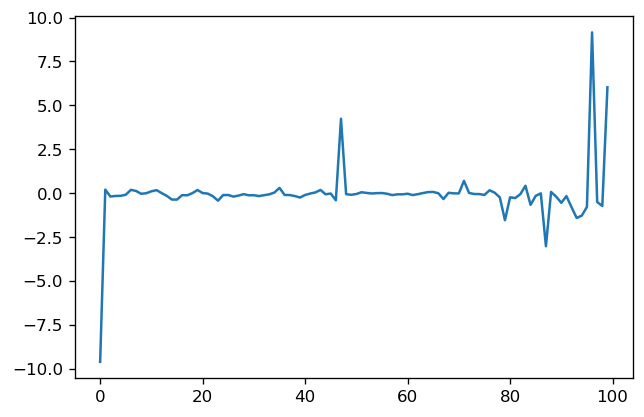

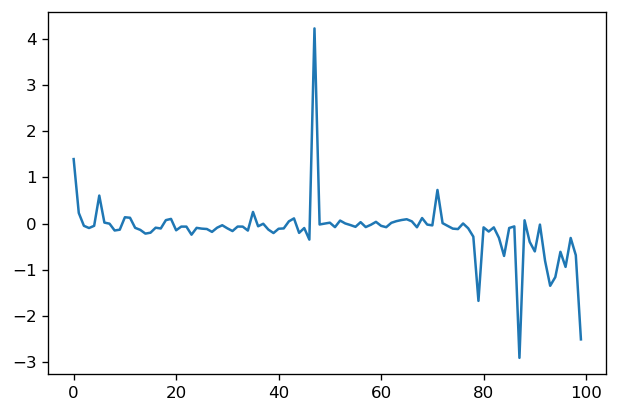

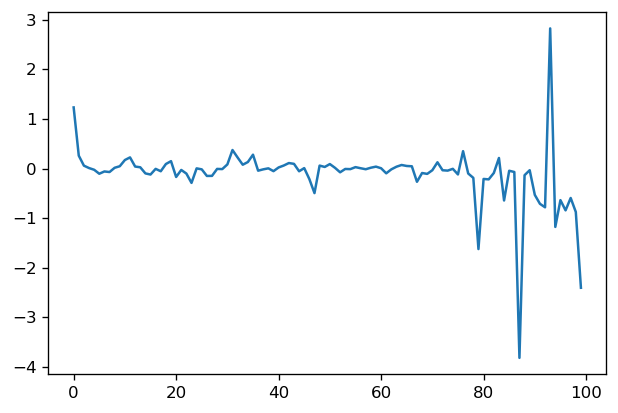

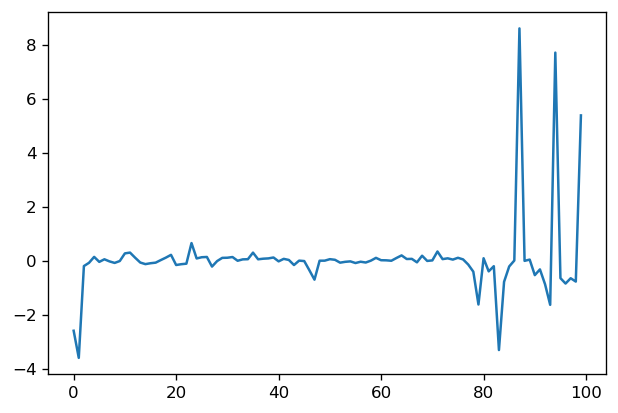

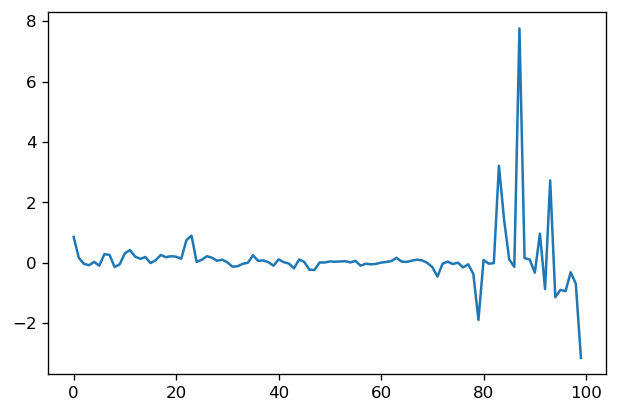

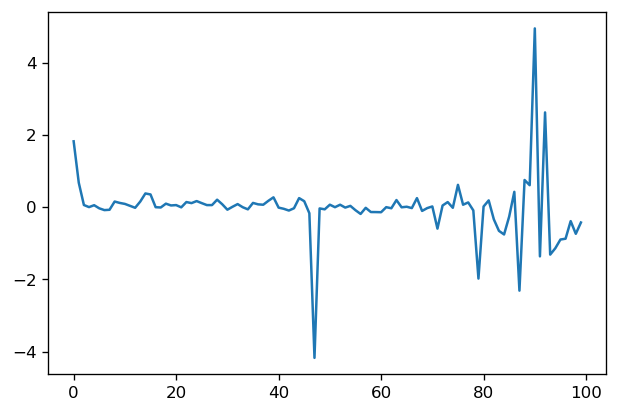

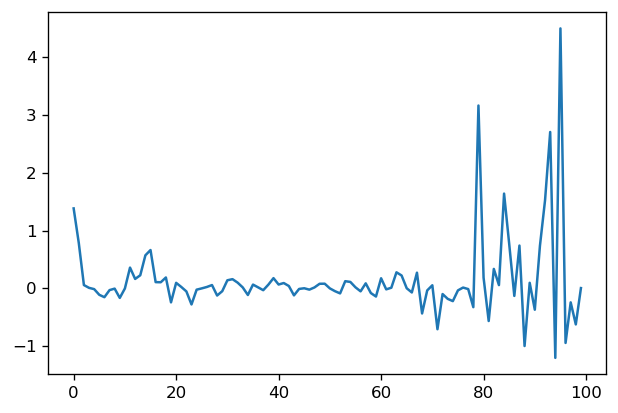

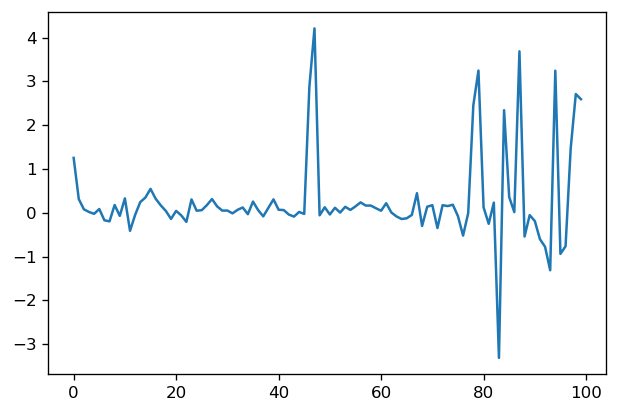

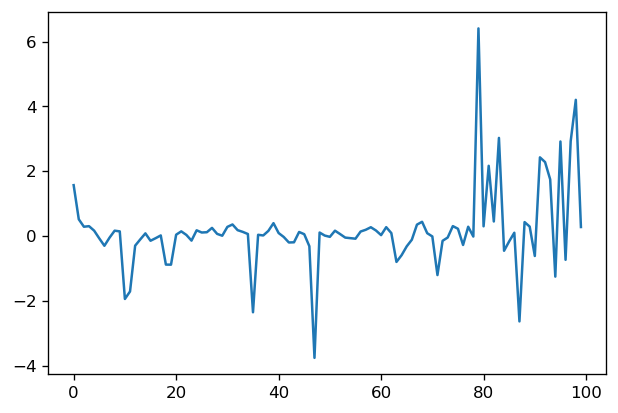

In [235]:
for j in range(len(h2a1)):
    plt.figure()
    plt.plot(h2a1[j]-(np.sum(h2a1, axis=0)/len(h2a1)))

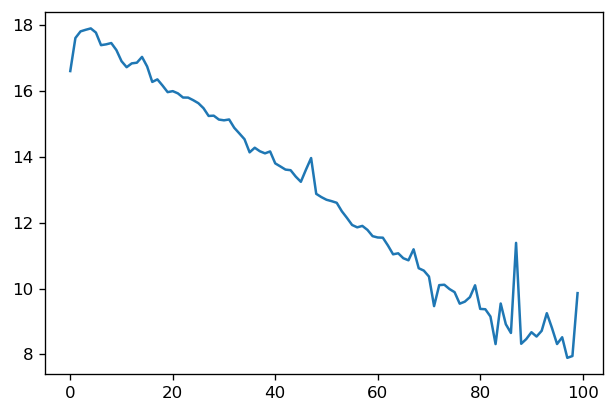

In [236]:
plt.plot(np.sum(h2a1, axis=0)/len(h2a1))

In [232]:
for k in range(len(h2a1[3])):
    h2a1[3][]

array([18.00926679, 17.84684713, 17.76902668, 17.76902668, 17.85956196,
       18.38871485, 17.42010021, 17.421773  , 17.3131801 , 17.11677289,
       17.04893333, 16.85514285, 16.75314195, 16.72932092, 16.8237689 ,
       16.55303161, 16.19160861, 16.25245307, 16.24684045, 16.07244692,
       15.85617471, 15.86855816, 15.7415347 , 15.56422869, 15.63317522,
       15.52536783, 15.36525967, 15.0676314 , 15.16615043, 15.10154361,
       15.01117711, 14.97808117, 14.82263012, 14.64950262, 14.38897526,
       14.39364134, 14.22242554, 14.17011242, 13.98020198, 13.9636493 ,
       13.69360445, 13.60802575, 13.66515422, 13.71067424, 13.2025104 ,
       13.14861644, 13.26939482, 18.19699724, 12.86029473, 12.78139853,
       12.71950374, 12.58058311, 12.67291138, 12.35245051, 12.11646912,
       11.86285351, 11.8921906 , 11.82958801, 11.75747465, 11.63147387,
       11.50458771, 11.46860781, 11.32493813, 11.09488285, 11.1500168 ,
       11.01660885, 10.90820584, 11.1143312 , 10.73927546, 10.52